<br>

## 태스크와 데이터 <br><br>

- __Task__ : '원하는 조건에 맞는' '이미지 생성' <br>

    무채색 그림을 입력으로 주면 채색된 이미지를 출력하는 cGAN 모델을 만들어 보자. <br><br>

- __Data__ : 포켓몬스터 드로잉 데이터 <br>
    
    학습용 데이터 셋에 830개의 이미지가 있으며, <br>
    각 (256x256) 크기의 이미지 쌍이 나란히 붙어 (256x512) 크기의 이미지로 구성 <br>
    출처 : [kaggle - Sketch2Pokemon](https://www.kaggle.com/norod78/sketch2pokemon)

<br>

<br>

### 데이터 불러오기

<br>

In [36]:
# 데이터 불러와서 개수 확인

import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


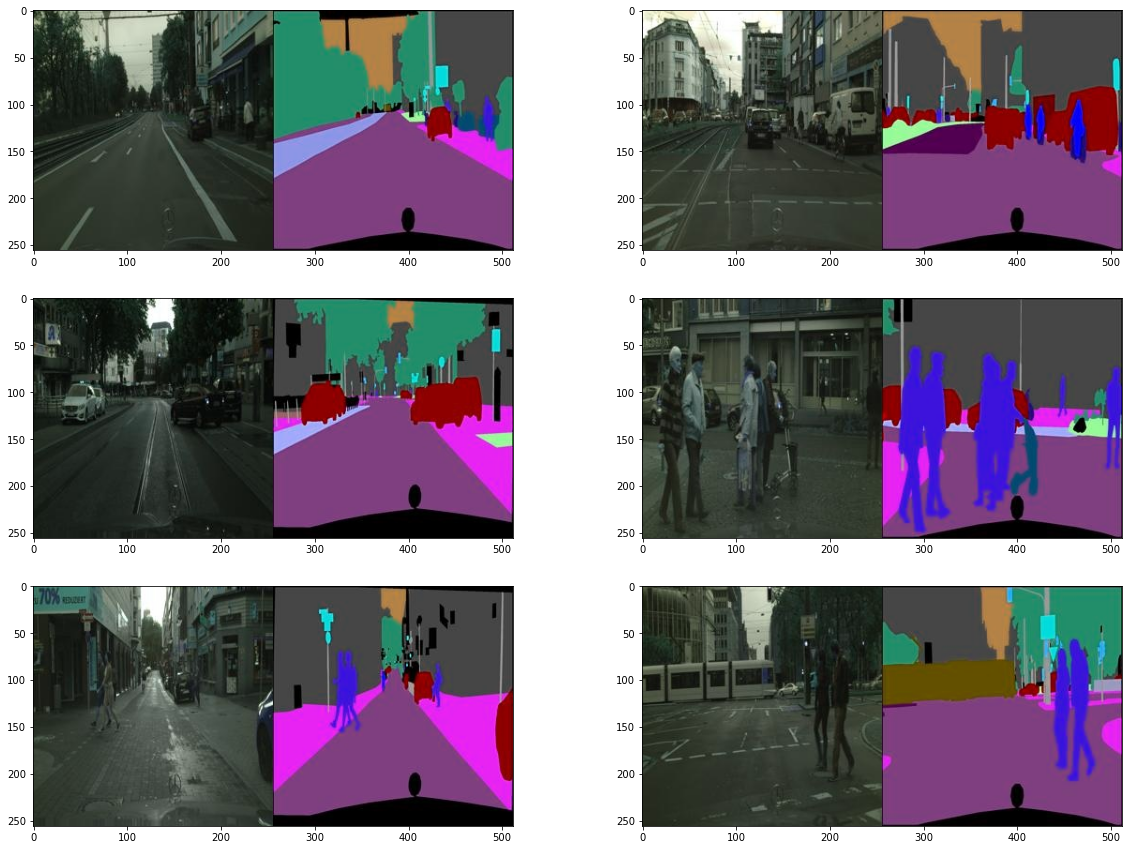

In [37]:
# OpenCV 를 활용하여 이미지 읽어와서 matplotlib 으로 시각화하여 확인

import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

<br>

일부는 제대로 스케치 되지 않은 이미지도 확인할 수 있습니다. <br>
출처를 확인해보니 직접 그려서 만든 데이터셋이 아닌 스케치 생성 모델을 이용해서 만들었다고 합니다...

<br>

In [38]:
# 이미지 하나 확인

f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


<br>

### 데이터 전처리 : 데이터 수정 <br><br>


기본으로 주어지는 데이터가 하나의 이미지 데이터 안에 input 용 데이터와 label 데이터가 합쳐져 있습니다. <br>
이를 서로 다른 두 개의 이미지 (매트릭스) 데이터로 나누어 줍니다. <br><br>

(256, 512, 3) 의 원본 데이터 -> 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용 <br>

첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력하여 <br>
두 번째 그림과 같은 채색된 이미지를 생성하는 것이 이번 단계의 목표

<br>

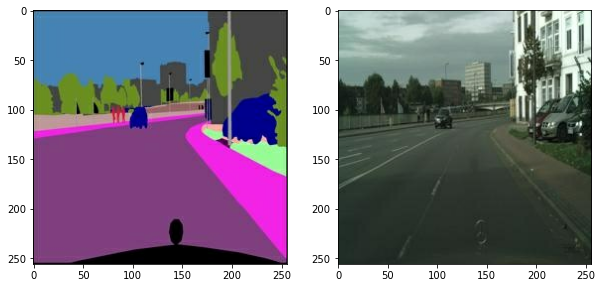

In [39]:
# OpenCV 를 활용하여 이미지 두 개로 분할

import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    sketch= img[:, w:, :] 
    sketch= tf.cast(sketch, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

<br>

### 데이터 전처리 : 데이터 Augmentation <br><br>


학습에 사용할 수 있는 데이터의 수는 약 800개뿐입니다. <br>
학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 augmentation 방법을 적용합니다. <br>

augmentation 방법 외에 더 많은 방법을 활용한다면 <br>
더욱더 다양한 데이터셋을 만들어 좋은 일반화 결과를 기대해 볼 수 있습니다 <br><br>


```apply_augmentation()``` 함수 <br>
스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용합니다. <br>


<br>

In [40]:
# tensorflow 모듈을 활용해 데이터 augmentation 수행
# 빠른 텐서플로 연산을 위해 @tf.function()을 사용

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


<br>

```apply_augmentation(sketch, colored)``` 함수의 프로세스 <br>

1. 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
2. 의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
3. 의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop) 
4. 의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
5. 의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down) 
6. 의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)

<br>

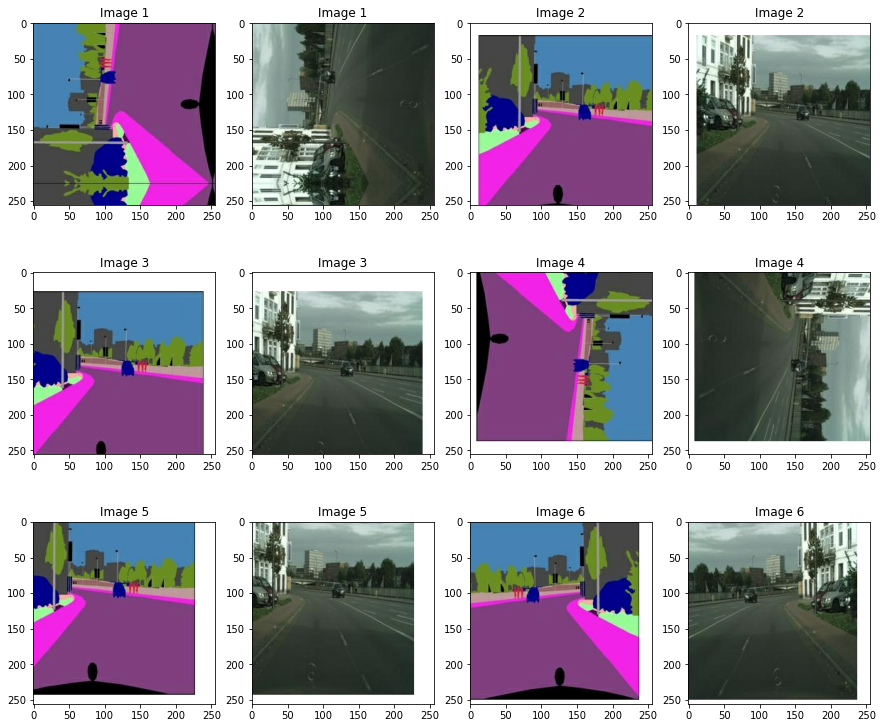

In [41]:
# augmentation 적용 후 데이터 시각화 하여 확인

plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

<br>

### 학습용 데이터셋 구성

위의 데이터 전처리 과정을 거친 데이터를 <br>
모델에 따른 데이터 학습에 맞도록 데이터셋 구성하는 함수 작성 <br><br>

```get_train(img_path)``` 함수 <br>

- 이미지 불러와 전처리 <br>
- 이미지 셔플하여 배치 사이즈 만큼 추출 <br>
- 하나만 불러와서 이미지 확인

<br>

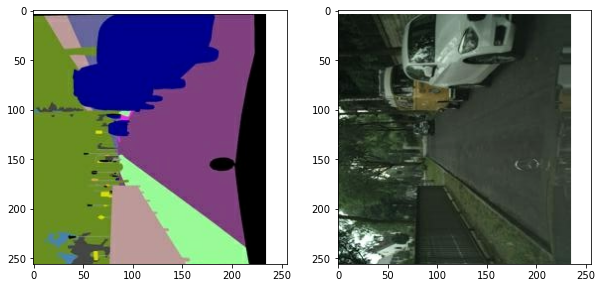

In [42]:
# 학습용 데이터셋 구성하는 함수 작성

from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

<br>

## 모델 구성 : Generator 모델

<br>

<br>

### Generator 의 구성요소 <br><br>


#### pix2pix 논문에서 말하는 Generator 를 구성하는데 필요한 요소들 <br><br>


6.1. Network architectures <br>
Let CK denote a Convolution-BatchNorm-ReLU layer with k filters. CDK denotes a Convolution-BatchNrom-Dropout-ReLU layer with a dropout rate of 50%. All convolutions are 4x4 spatial filters applied with stride 2. Convolutions in the encoder, and in the discriminator, downsample by a factor of 2, whereas in the decoder they upsample by a factor of 2. <br><br>

6.1.1 Generator architectures <br>
The encoder-decoder architecture consists of: <br>
__encoder:__ <br>
C64-C128-C256-C512-C512-C512-C512-C512 <br>
__decoder:__ <br>
CD512-CD512-CD512-CD512-CD256-CD128-CD64 <br>
After the last layer in the decoder, a convolution is applied to map to the number of output channels (3 in general, except in colorization, whiere it is 2), followed by a Tanh function. As an exception to the above notation, Batch-Norm is not applied to the first C64 layer in the encoder. All ReLUs in the encoder are leaky, with slope 0.2, while ReLUs in the decoder are not leaky. <br><br>


#### pix2pix 모델에서 이미지 데이터 형태변화 확인 다이어그램

ENCODE 또는 DECODE라고 쓰인 각각의 블록을 기준으로 양쪽에 쓰인 입출력 크기에 집중해주세요. <br>
"in"이라고 쓰여진 입력 부분부터 윗줄의 화살표를 쭉 따라가면 계산된 결과의 (width, height) 크기가 점점 절반씩 줄어들며 <br>
최종적으로 (1,1)이 되고, 채널의 수는 512까지 늘어나는 것을 확인할 수 있습니다. <br>
처음 입력부터 시작해서 (1,1,512) 크기를 출력하는 곳까지가 Encoder 부분입니다. <br><br>

이어서 아랫줄 화살표를 따라가면 (width, height) 크기가 점점 두 배로 늘어나 다시 (256, 256) 크기가 되고, <br>
채널의 수는 점점 줄어들어 처음 입력과 같이 3채널이 됩니다. <br>
(1,1,512)를 입력으로 최종 출력까지의 연산들이 Decoder 부분입니다.

<br>

<br>

### Generator 구현 <br><br>


#### Pix2Pix 구조 구현. <br>

cGAN 구현과 같이 Tensorflow 의 Subclassing 방법을 이용해 모델을 생성.

<br>

<br>

### Encoder 부분 구현 <br><br>

#### 논문을 토대로 Generator의 Encoder 부분을 구현. <br>

__EncoderBlock__ <br>

"C64", "C128" 등으로 쓰여진 것과 같이 <br>
"Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 하나의 레이어로 (클래스) 작성 <br>

__init__() 메서드에서 n_filters, use_bn를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정 할 수 있습니다. <br>
이외 Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 <br>
모든 곳에서 고정되어 사용하므로 각각의 값을 지정했습니다.

__Encoder__ <br>

 EncoderBlock 을 여러개 가져다 인코더 모델 생성하는 클래스 작성 <br>

 각 블록을 거치면서 사용할 필터의 개수를 filters라는 리스트에 지정해 두었으며, <br>
 blocks이라는 리스트에는 사용할 블록들을 정의해 넣어두고, call() 메서드에서 차례대로 블록들을 통과합니다. <br>
 논문에서 설명한 대로 Encoder 첫 번째 블록에서는 BatchNorm을 사용하지 않습니다. <br>

 ```get_summary``` 는 레이어가 제대로 구성되었는지 확인하기 위한 용도로 따로 작성 <br>
 ( 위에서 구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 확인 해보자 )

 <br>

In [43]:
# Conv -> BatchNorm -> LeakyReLU 합쳐진 하나의 레이어 클래스로 작성

from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [44]:
# 위의 EncoderBlock 을 여러개 가져다 인코더 모델 생성하는 클래스 작성

class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [45]:
# 위의 Encoder 에서 작성한 메서드 get_summary() 로 Generator 모델 구조 확인

Encoder().get_summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_32 (EncodeBlock (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_33 (EncodeBlock (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_34 (EncodeBlock (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_35 (EncodeBlock (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_36 (EncodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_37 (EncodeBlock (None, 4, 4, 512)         4196

<br>

블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, <br>
사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨을 확인

<br>

<br>

### Decoder 부분 구현 <br><br>

#### 논문을 토대로 Generator의 Decoder 부분을 구현. <br>

처음 세 개의 블록에서만 Dropout을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력

<br>

In [46]:
# Conv -> BarchNorm -> Dropout -> ReLU 를 갖는 Decoder Block 레이어를 클래스로 작성

class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [47]:
# Decoder Block 레이어를 쌓아 Decoder 모델 클래스로 작성

class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [48]:
# Decoder 모델 구성 get_summary 메소드로 확인

Decoder().get_summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block_28 (DecodeBlock (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_29 (DecodeBlock (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_30 (DecodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_31 (DecodeBlock (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_32 (DecodeBlock (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_33 (DecodeBlock (None, 64, 64, 128)       5248

<br>

(width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 <br>
최종 (256,256,3) 크기로 알맞게 출력되었습니다. 

<br>

<br>

### Generator 구성 <br>

Encoder-Decoder 연결하여 최종 모델 구축 <br>

구성한 Encoder와 Decoder를 연결시키면 <br>
Encoder에서 (256,256,3) 입력이 (1,1,512)로 변환되고, <br>
Decoder를 통과해 다시 원래 입력 크기와 같은 (256,256,3)의 결과를 얻을 수 있습니다. <br>

```tf.keras.Model``` 을 상속받아 Encoder 와 Decoder 를 연결해 Generator 를 구성해 봅시다.

<br>

In [49]:
# Encoder-Decoder 연결된 Generator 모델 생성하는 클래스 작성

class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_3 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_3 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


<br>

우리가 원하는 최종 모델인 Generator 모델의 구조와 파라미터수를 확인해본 결과 <br>
Generator를 잘 작동시키기 위해서는 약 4000 만 개의 파라미터를 잘 학습시켜야 합니다 ..

<br>

<br>

## U-Net <br><br>

<br>

<br>

### Generator 의 재구성 <br><br>


단순한 Encoder-Decoder 구조에 비해 <br>
Encoder와 Decoder 사이를 skip connection으로 연결한 U-Net 구조를 사용한 결과가 훨씬 더 실제 이미지에 가까운 품질을 보입니다. <br><br>


이전 단계에서 구현했던 Generator는 위 그림의 Encoder-decoder 구조입니다. <br>
Encoder에서 출력된 결과를 Decoder의 입력으로 연결했고, 이 외에 추가적으로 Encoder와 Decoder를 연결시키는 부분은 없었습니다. <br>
더 좋은 결과를 기대하기 위해 이전에 구현했던 것들을 조금 수정하여 위 그림의 U-Net 구조를 만들고 실험해봅시다. <br>
(아래 단락부터는 두 가지 구조를 각각 "Encoder-Decoder Generator" 및 "U-Net Generator"라는 용어로 구분하여 사용하겠습니다) 

<br>

<br>

### Encoder 와 Decoder 에 필요한 기본 블록 준비

<br>

In [50]:
# Encoder 및 Decoder 에 사용되는 기본 블록 클래스 정의
# (위에서 본거랑 같은거)

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


<br>

그대로 가져다가 사용 <br>
여기서 특별히 수정해야 할 부분은 없습니다. 

<br>

<br>

### U-Net Generator 구현 <br><br>


#### 정의된 블록들을 이용해 한 번에 U-Net Generator 를 정의 <br>

__init__() 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고, <br>
call()에서 forward propagation 하도록 합니다. <br><
이전 구현에는 없었던 skip connection이 call() 내부에서 어떻게 구현되었는지 잘 확인해봅시다. <br><br>


#### skip connection 코드 <br>

먼저, __init__() 에서 정의된 encode_blocks 및 decode_blocks 가 <br>
call() 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행합니다. <br>

이때, Encoder와 Decoder 사이의 skip connection 을 위해 <br>
features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담았습니다. <br>

이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데, <br>
features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용됩니다. 

<br>

In [51]:
# 기본 Encoder, Decoder 블록을 사용하여 U-Net Generator 클래스 작성
# skip connection 구현

class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]        # 1.
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):     # 2.
            x = block(x)
            x = layers.Concatenate()([x, feat])     # 3.and
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


<br>

1. call() 내에서 ' features = features\[:-1\]' 는 왜 필요할까요? <br>

    Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, <br>
    Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아닙니다. <br><br>

2. call() 내의 Decoder 연산 부분에서 features[::-1] 는 왜 필요할까요? <br>

    Skip connection은 Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, <br>
    Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는.. 등 대칭을 이룹니다 <br>
    (맨 위 U-Net 구조 사진 참고) <br>
    features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, <br>
    이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결합니다. <br><br>

3. 데이터 A 크기 : (32,128,128,200) #(batch, width, height, channel) <br>
    데이터 B 크기 : (32,128,128,400) #(batch, width, height, channel) <br>
    두 데이터가 있을 때, 여기서 사용되는 skip connection은 layers.Concatenate() 결과의 크기는 무엇일까요? <br>

    (128,128,600) <br>
    layers.Concatenate() 내에 별다른 설정이 없다면 가장 마지막 축(채널 축)을 기준으로 서로 연결됩니다.





<br>

In [52]:
# U-Net 구조 Generator 내부의 각 출력이 적절한지 확인

UNetGenerator().get_summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_48 (EncodeBlock)   (None, 128, 128, 64) 3072        input_10[0][0]                   
__________________________________________________________________________________________________
encode_block_49 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_48[0][0]            
__________________________________________________________________________________________________
encode_block_50 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_49[0][0]            
____________________________________________________________________________________________

<br>

#### U-Net Generator 의 parameter 개수 <br><br>


Encoder-Decoder Generator 구조에서 학습해야 할 파라미터는 약 4000만 개 였는데, <br>
Skip connection을 추가한 U-Net Generator의 파라미터는 약 5500만 개로 꽤나 많이 늘어났습니다. <br><br>


U-Net Generator의 Decoder 구조 내 파라미터가 많아졌습니다. <br>
이 부분의 각 convolution 레이어에서 사용된 필터의 수는 두 종류의 Decoder에서 동일하지만, 그 크기가 다릅니다. <br>

예를 들어, 이전 Decoder 블록의 출력의 크기가 (16,16,512)라면, <br>
Encoder-decoder Generator의 경우, Decoder의 다음 블록에서 계산할 convolution의 필터 크기는 4x4x512 입니다. <br>
U-Net Generator의 경우, Encoder 내 블록 출력이 함께 연결되어 <br>
Decoder의 다음 블록에서 계산할 convolution의 필터 크기는 4x4x(512+512) 입니다. <br><br>

정리하면, <br>
U-Net Generator에서 사용한 skip-connection으로 인해 Decoder의 각 블록에서 입력받는 채널 수가 늘어났고, <br>
이에 따라 블록 내 convolution 레이어에서 사용하는 필터 크기가 커지면서 학습해야 할 파라미터가 늘어났습니다.

<br>

<br>

### U-Net 의 Discriminator 구성 <br><br>

Generator만으로 좋은 결과를 도출하기에는 부족합니다. <br>
조금 더 사실적인 이미지를 생성하기 위한 Pix2Pix를 완성시키기 위해서는 Discriminator가 필요합니다.

<br>

<br>

### U-Net Discriminator 의 구성요소 <br><br>

__Pix2Pix 논문 발췌__ <br>

6.1. Network architectures <br>

We adapt our network architectures from those in \[44\]. Code for the models is available at [https://github.com/phillipi/pix2pix](https://github.com/phillipi/pix2pix). <br>
Let Ck denote a Convolution-BatchNorm-ReLU layer with k filters. CDk denotes a Convolution-BatchNorm-Dropout-ReLU layer with a dropout rate of 50%. All convolutions are 4x4 spatial filters applied with stride 2. Convolutions in the encoder, and in the discriminator, downsample by a factor of 2, whereas in the decoder they upsample by a factor of 2. <br>

6.1.2 Discriminator architectures <br>

The 70x70 discriminator architecture is : <br>
C64-128-256-C512 <br>
After the last layer, a convolution is applied to map to a 1-dimensional output, followed by a Sigmoid function. As an exception to the above notation, BatchNorm is not applied to the first C64 layer. All ReLUs are leaky, with slope 0.2. <br><br>

~ 나중에 정리

<br>

<br>

### Discrimainator 구현하기

<br>

In [53]:
# Dscriminator 만들 기본 블럭 클래스 작성

class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


<br>

__처리과정__ <br>


패딩 레이어 통과 layers.ZeroPadding2D() → (130,130,32) <br>
Convolution 레이어 통과 layers.Conv2D(64,4,1,"valid") → (127,127,64) <br>
BatchNormalization 레이어 통과  layers.BatchNormalization() → (127,127,64) <br>
LeakyReLU 활성화 레이어 통과 layers.LeakyReLU(0.2) → (127,127,64) <br>

<br>

<br>

__init__() 에서 필요한 만큼 많은 설정을 가능하게끔 했습니다. <br>
필터의 수(n_filters), <br>
필터가 순회하는 간격(stride), <br>
출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad), <br>
BatchNorm의 사용 여부(use_bn), <br>
활성화 함수 사용 여부(act)가 설정 가능합니다. 

<br>

In [54]:
# Discriminator 작성

class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [55]:
# Discriminator 모델 확인

Discriminator().get_summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_24 (Concatenate)    (None, 256, 256, 6)  0           input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
disc_block_15 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_24[0][0]       

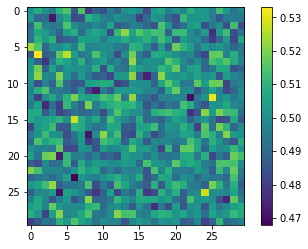

In [56]:
# 임의의 (256,256,3) 크기 입력으로 (30,30) 출력 확인

x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

<br>

### 모델 학습

<br>

In [57]:
# 손실함수(loss) 정의

from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [58]:
# Optimizer 정의

from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [59]:
# 학습과정 (train_step) 정의 ?

@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [60]:
# 위 학습을 위해 정의한 함수들로 10 Epoch 학습 진행

EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

            
Discriminator_loss:1.1790

EPOCH[5] - STEP[160]                     
Generator_loss:0.8035                     
L1_loss:0.1759                     
Discriminator_loss:1.2887

EPOCH[5] - STEP[170]                     
Generator_loss:1.5546                     
L1_loss:0.1961                     
Discriminator_loss:1.9216

EPOCH[5] - STEP[180]                     
Generator_loss:1.4974                     
L1_loss:0.1593                     
Discriminator_loss:1.0881

EPOCH[5] - STEP[190]                     
Generator_loss:1.6607                     
L1_loss:0.1781                     
Discriminator_loss:0.4646

EPOCH[5] - STEP[200]                     
Generator_loss:1.8192                     
L1_loss:0.2309                     
Discriminator_loss:0.2639

EPOCH[5] - STEP[210]                     
Generator_loss:1.7882                     
L1_loss:0.1638                     
Discriminator_loss:0.4453

EPOCH[5] - STEP[220]                     
Generator_loss:0.7967         

<br>

### 모델 테스트 <br><br>

결과를 봅시다.

<br>

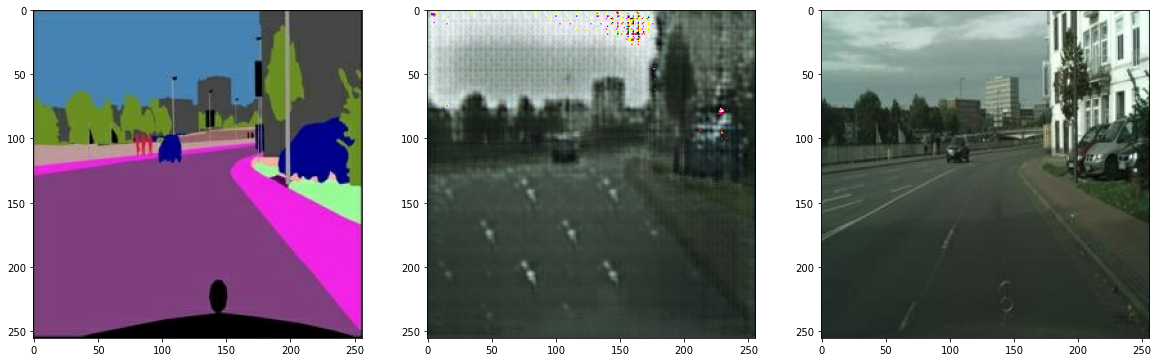

In [61]:
# 학습된 모델 테스트

test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

<br>

## Epoch 증가하여 학습 <br><br>

### Epoch = 20

<br>

In [63]:
# 학습과정 (train_step) 정의 ?

@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [64]:
# 위 학습을 위해 정의한 함수들로 20 Epoch 학습 진행

EPOCHS = 20

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

               
L1_loss:0.1828                     
Discriminator_loss:0.6231

EPOCH[15] - STEP[170]                     
Generator_loss:2.2309                     
L1_loss:0.1534                     
Discriminator_loss:0.5744

EPOCH[15] - STEP[180]                     
Generator_loss:1.5885                     
L1_loss:0.1729                     
Discriminator_loss:0.5804

EPOCH[15] - STEP[190]                     
Generator_loss:2.2703                     
L1_loss:0.1861                     
Discriminator_loss:1.2170

EPOCH[15] - STEP[200]                     
Generator_loss:0.2771                     
L1_loss:0.1684                     
Discriminator_loss:1.7693

EPOCH[15] - STEP[210]                     
Generator_loss:0.5332                     
L1_loss:0.1642                     
Discriminator_loss:1.7505

EPOCH[15] - STEP[220]                     
Generator_loss:1.4645                     
L1_loss:0.1800                     
Discriminator_loss:1.0522

EPOCH[15] - STEP[230]      

<br>

### 모델 테스트 <br><br>

결과를 봅시다.

<br>

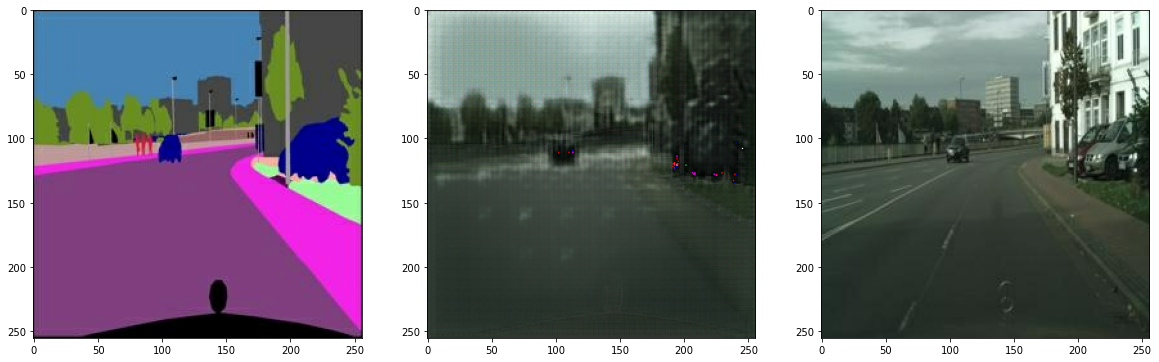

In [65]:
# 학습된 모델 테스트

test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

<br>

## Epoch 증가하여 학습 <br><br>

### Epoch = 40

<br>

In [67]:
# 학습과정 (train_step) 정의 ?

@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [68]:
# 위 학습을 위해 정의한 함수들로 40 Epoch 학습 진행

EPOCHS = 40

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

               
L1_loss:0.1945                     
Discriminator_loss:0.1905

EPOCH[35] - STEP[170]                     
Generator_loss:1.4776                     
L1_loss:0.1589                     
Discriminator_loss:1.3093

EPOCH[35] - STEP[180]                     
Generator_loss:2.8822                     
L1_loss:0.1567                     
Discriminator_loss:1.3221

EPOCH[35] - STEP[190]                     
Generator_loss:2.6745                     
L1_loss:0.1745                     
Discriminator_loss:0.3000

EPOCH[35] - STEP[200]                     
Generator_loss:1.6303                     
L1_loss:0.1761                     
Discriminator_loss:0.5898

EPOCH[35] - STEP[210]                     
Generator_loss:1.8628                     
L1_loss:0.2077                     
Discriminator_loss:0.2867

EPOCH[35] - STEP[220]                     
Generator_loss:2.3757                     
L1_loss:0.1613                     
Discriminator_loss:0.8121

EPOCH[35] - STEP[230]      

<br>

### 모델 테스트 <br><br>

결과를 봅시다.

<br>

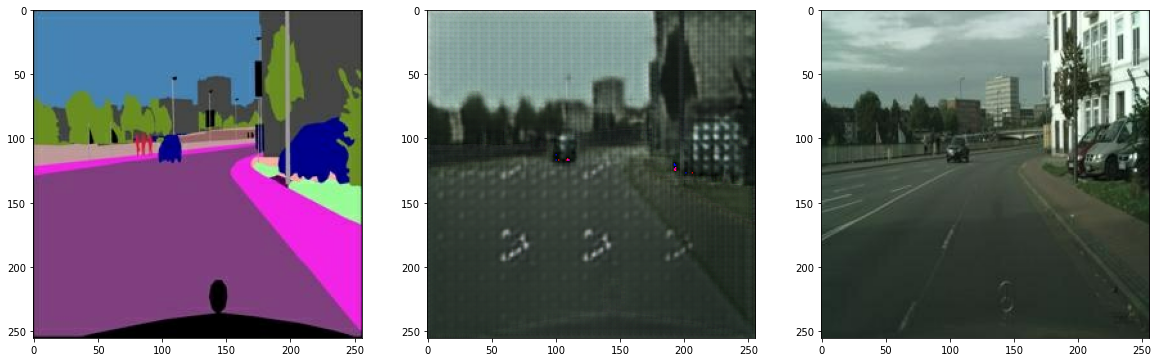

In [69]:
# 학습된 모델 테스트

test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

<br>

## Epoch 증가하여 학습 <br><br>

### Epoch = 80

<br>

In [76]:
# 학습과정 (train_step) 정의 ?

@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [77]:
# 위 학습을 위해 정의한 함수들로 80 Epoch 학습 진행

EPOCHS = 80

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

               
L1_loss:0.1855                     
Discriminator_loss:0.6609

EPOCH[75] - STEP[170]                     
Generator_loss:1.1759                     
L1_loss:0.1432                     
Discriminator_loss:0.5782

EPOCH[75] - STEP[180]                     
Generator_loss:0.8435                     
L1_loss:0.1677                     
Discriminator_loss:0.8135

EPOCH[75] - STEP[190]                     
Generator_loss:1.6976                     
L1_loss:0.1424                     
Discriminator_loss:1.4331

EPOCH[75] - STEP[200]                     
Generator_loss:1.7386                     
L1_loss:0.2066                     
Discriminator_loss:0.2678

EPOCH[75] - STEP[210]                     
Generator_loss:1.2686                     
L1_loss:0.1760                     
Discriminator_loss:0.4253

EPOCH[75] - STEP[220]                     
Generator_loss:0.2876                     
L1_loss:0.1405                     
Discriminator_loss:2.2610

EPOCH[75] - STEP[230]      

<br>

### 모델 테스트 <br><br>

결과를 봅시다.

<br>

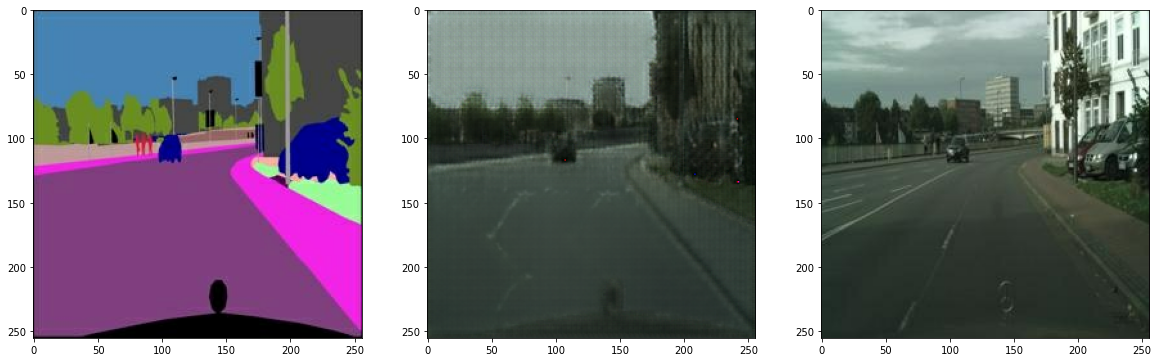

In [78]:
# 학습된 모델 테스트

test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))